In [6]:
import pandas as pd

import plotly.express as px
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt


from tqdm.notebook import tqdm
tqdm.pandas()
pd.options.display.max_columns = 999

import plotly.graph_objects as go
import ipyvuetify as v

from ipywidgets import interact, Checkbox, Select, Output, widgets
import ipywidgets
from datetime import datetime

from IPython.display import display


import continental_level_plots
import country_level_plots
import flight_level_plots
import time

In [7]:
#### Import various plot file. In case the source file is modified, please rerun preprocess.py ####

#import preprocess
#preprocess.preprocess()

#read continental level data
continental_flows=pd.read_csv('./plot_files/continental_flows.csv',sep=',', keep_default_na=False, na_values=['', 'NaN'], index_col=0)
continental_flows_non_dir=pd.read_csv('./plot_files/continental_flows_non_dir.csv',sep=',', keep_default_na=False, na_values=['', 'NaN'], index_col=0)
conti_scatter=pd.read_csv('./plot_files/conti_scatter.csv',sep=',', keep_default_na=False, na_values=['', 'NaN'], index_col=0)
flights_df_conti=pd.read_csv('./plot_files/flights_df_conti.zip',compression='zip',sep=',', keep_default_na=False, na_values=['', 'NaN'], index_col=0)

#read country level data
country_flows=pd.read_csv('./plot_files/country_flows.csv',sep=',', keep_default_na=False, na_values=['', 'NaN'], index_col=0)
country_fixed=pd.read_csv('./plot_files/country_fixed.csv',sep=',', keep_default_na=False, na_values=['', 'NaN'], index_col=0)

#read flight_level_data
flights_df=pd.read_csv('./plot_files/flights_df.zip',compression='zip', sep=',',keep_default_na=False, na_values=['', 'NaN'], index_col=0)

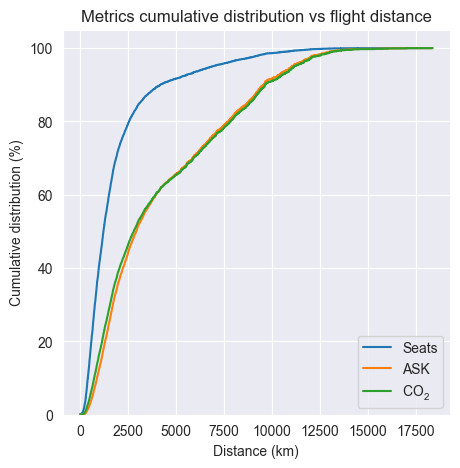

In [46]:
##### DEV ZONE ######
sns.set_style("darkgrid")


def distance_ecdf_plot_country(flights_df):
    
    
    # Create a new figure with a single subplot
    fig, ax = plt.subplots(figsize=(5,5))
    sns.ecdfplot(flights_df, x='distance_km', weights='seats', label='Seats',stat='percent', ax=ax)
    sns.ecdfplot(flights_df, x='distance_km', weights='ask', label= 'ASK', stat='percent',ax=ax)
    sns.ecdfplot(flights_df, x='distance_km', weights='co2', label= '$\mathregular{CO_2}$',stat='percent', ax=ax)
    
    ax.legend()

    # Set the title, x-axis label, and y-axis label
    ax.set_title("Metrics cumulative distribution vs flight distance")
    ax.set_xlabel("Distance (km)")
    ax.set_ylabel("Cumulative distribution (%)")

    # Set the margins
    # ax.set_margin(left=5, right=5, top=60, bottom=5)

    return fig

# distance_ecdf_plot_country(flights_df)

In [ ]:
### MAIN FRONT

### CONTINENTAL FLOWS FRONTEND
continent_select = v.Select(v_model=['AF','AS','EU','NA','SA','OC'],
                   multiple=True,
                   clearable=True,
                   chips=True,
                   items=[
                            {'label': 'Africa', 'value': 'AF'},
                            {'label': 'Asia', 'value': 'AS'},
                            {'label': 'Europe', 'value': 'EU'},
                            {'label': 'North America', 'value': 'NA'},
                            {'label': 'South America', 'value': 'SA'},
                            {'label': 'Oceania', 'value': 'OC'}
                        ],
                            item_text='label',
                            item_value='value'
                           )



value_watched_radio = v.RadioGroup(
    v_model='CO2 (Mt)',  # Set the initial selected value here
    row=True,
    children=[
        v.Radio(label='CO\u2082', value='CO2 (Mt)'),
        v.Radio(label='ASK', value='ASK (Bn)'),
        v.Radio(label='SEATS', value='Seats (Mn)'),
    ],
     class_='mb-3'
)




output_figure_conti1 = Output()
output_figure_conti2 = Output()
output_figure_conti3 = Output()



def render_initial_plots_conti():
    
    # continental_flows_non_dir[['AV1', 'AV2']] = continental_flows_non_dir['group_col'].copy().apply(lambda x: pd.Series(x))
    with output_figure_conti1:
        fig_conti_1 = continental_level_plots.continental_map_plot(conti_scatter, continental_flows_non_dir, 'CO2 (Mt)')
        display(fig_conti_1)
        
    with output_figure_conti2:
        fig_conti_2=continental_level_plots.continental_treemap_plot(continental_flows,'CO2 (Mt)')
        display(fig_conti_2)
        
    with output_figure_conti3:
        fig_conti_3=continental_level_plots.distance_histogramm_plot_continent(flights_df_conti,'CO2 (Mt)')
        display(fig_conti_3)
        
        
def plots_update_conti(change):

    filtered_values = continent_select.v_model
    value_watched_conti = value_watched_radio.v_model
    
    filtered_df_depart = conti_scatter[conti_scatter['departure_continent'].isin(filtered_values)].reset_index()
    filtered_df = continental_flows[continental_flows['departure_continent'].isin(filtered_values)].reset_index()
    filtered_fl_df = flights_df_conti[flights_df_conti['departure_continent'].isin(filtered_values)].reset_index()
    
    # continental_flows_non_dir[['AV1', 'AV2']] = continental_flows_non_dir['group_col'].copy().apply(lambda x: pd.Series(x))
    filtered_non_dir=continental_flows_non_dir[(continental_flows_non_dir.AV1.isin(filtered_values))|(continental_flows_non_dir.AV2.isin(filtered_values))].reset_index()

    with output_figure_conti1:
        output_figure_conti1.clear_output()
        fig_conti_1=continental_level_plots.continental_map_plot(filtered_df_depart, filtered_non_dir, value_watched_conti)
        display(fig_conti_1)
        
        
    with output_figure_conti2:
        output_figure_conti2.clear_output()
        fig_conti_2=continental_level_plots.continental_treemap_plot(filtered_df, value_watched_conti)
        display(fig_conti_2)
        
    with output_figure_conti3:
        output_figure_conti3.clear_output()
        fig_conti_3=continental_level_plots.distance_histogramm_plot_continent(filtered_fl_df, value_watched_conti)
        display(fig_conti_3)
    

# # Connect the event handler to the controls 

continent_select.observe(plots_update_conti, names='v_model')
value_watched_radio.observe(plots_update_conti, names='v_model')


### PAGE ARCHITECTURE

## Define the rows

h_divider=v.Divider()

col_selects = v.Col(
    justify='center',  # Center the components horizontally
    no_gutters=False,
    cols='3',
    # class_='mb-4',  # Add margin at the bottom
    children=[
        v.Row(
            # cols='6',  # Adjust the column width as needed
            children=[
                v.Card(
                    outlined=False,
                    elevation=0,
                    children=[
                        v.CardText(
                            children=[
                                v.CardTitle(children="Indicator"),
                                value_watched_radio,
                            ]
                        ),
                    ]
                ),
            ],
        ),
        h_divider,    
        v.Row(
            # cols='6',  # Adjust the column width as needed
            children=[
                v.Card(
                    outlined=False,
                    elevation=0,
                    children=[
                        v.CardText(
                            children=[
                                v.CardTitle(children="Select 'departure' continents"),
                                continent_select,
                            ]
                        ),
                    ]
                ),
            ],
        ),
    ],
)


row_mega_map=v.Row(
            children=[
                v.Col(
                    xs12=True,
                    children=[
                        v.Card(
                            outlined=True,
                            elevation=0,
                            children=[
                                v.CardText(
                                    children=[output_figure_conti1,
                                    ]
                                ),
                                
                            ],
                        ),
                    ],
                    style_="max-width: 100%;"
                ),
            ],
        )


row_twoplots=v.Row(
                children=[
                    v.Col(
                        xs12=True,
                        children=[
                            v.Card(
                                outlined=True,
                                elevation=1,
                                children=[
                                    output_figure_conti2,
                                ],
                            ),
                        ],
                    ),
                    v.Col(
                        xs12=True,
                        children=[
                            v.Card(
                                outlined=True,
                                elevation=1,
                                children=[
                                    output_figure_conti3,
                                ],
                            ),
                        ],
                    ),
                ],
            )

row_disclaimer_cty = v.Col(
                    children=[
                        v.Card(
                            outlined=False,
                            elevation=0,
                            style_='width: 100%',
                            children=[
                                v.CardText(
                                    children=['Please wait for the plots to be rendered before changing the indicator or the continents. \n Doing so could break the process. \n If it happens please relaod the page.'], 
                                    class_="text-center teal--text darken-4",
                                    style_="font-size: 20px;"
                                ),
                            ]
                        ),
                    ],
                )


col_plots = v.Col(
    justify='center',  # Center the components horizontally
    no_gutters=False,
    # cols='10',
    # class_='mb-4',  # Add margin at the bottom
    children=[
        row_disclaimer_cty,row_mega_map, row_twoplots
    ],
)


In [4]:
### COUNTRIES FRONTEND

countries_autocomplete = v.Autocomplete(
    v_model=[],
    clearable=True,
    chips=True,
    label="Countries",
    items=list(country_flows.departure_country_name.unique()),
    multiple=True,
    variant="outlined"
)

def select_world(widget, event, data):
    countries_autocomplete.v_model = list()

select_world_button = v.Btn(children=["World View"], variant='outlined', color="cyan darken-3", class_="ma-2")
select_world_button.on_event("click", select_world)


value_watched_radio_ctry = v.RadioGroup(
    v_model='co2',  # Set the initial selected value here
    row=True,
    children=[
        v.Radio(label='CO\u2082 (kg)', value='co2'),
        v.Radio(label='ASK', value='ask'),
        v.Radio(label='SEATS', value='seats'),
    ],
     class_='mb-3'
)

# v-btn-toggle switch between the two main figures
toggle_button_ctry = v.BtnToggle(v_model='map', variant='outlined', children=[
    v.Btn(value='map', children=['Map'] ,variant='outlined'),
    v.Btn(value='tree', children=['Tree'], variant='outlined'),
])


output_figure_ctry1 = Output()
output_figure_ctry2 = Output()
output_figure_ctry3 = Output()
output_figure_ctry4 = Output()


def render_initial_plots_ctry():
    with output_figure_ctry1:
        fig_ctry_1=country_level_plots.countries_global_plot(country_fixed, 'co2')
        display(fig_ctry_1)
        
    with output_figure_ctry2:
        fig_ctry_2=country_level_plots.distance_histogramm_plot_country(flights_df, 'co2')
        display(fig_ctry_2)
        
    with output_figure_ctry3:
        fig_ctry_3=country_level_plots.aircraft_pie(flights_df, 'co2')
        display(fig_ctry_3)
        
    with output_figure_ctry4:
        fig_ctry_4=country_level_plots.aircraft_user_pie(flights_df, 'co2')
        display(fig_ctry_4)
        
        

def plots_update_ctry(change):
    filtered_values = countries_autocomplete.v_model
    value_watched_ctry = value_watched_radio_ctry.v_model
    active_main_graph_country=toggle_button_ctry.v_model
    
    if len(filtered_values)==0:         
        with output_figure_ctry1:
            output_figure_ctry1.clear_output(wait=True)
            if active_main_graph_country=='map':
                fig_ctry_1=country_level_plots.countries_global_plot(country_fixed, value_watched_ctry)
            else:
                fig_ctry_1=country_level_plots.countries_treemap_plot(country_flows, value_watched_ctry)
            display(fig_ctry_1)

        with output_figure_ctry2:
            output_figure_ctry2.clear_output(wait=True)
            # fig_ctry_2=country_level_plots.distance_histogramm_plot_country(flights_df, value_watched_ctry)
            fig_ctry_2=country_level_plots.distance_ecdf_plot_country(flights_df)
            display(fig_ctry_2)

        with output_figure_ctry3:
            output_figure_ctry3.clear_output(wait=True)
            fig_ctry_3=country_level_plots.aircraft_pie(flights_df, value_watched_ctry)
            display(fig_ctry_3)

        with output_figure_ctry4:
            output_figure_ctry4.clear_output(wait=True)
            fig_ctry_4=country_level_plots.aircraft_user_pie(flights_df, value_watched_ctry)
            display(fig_ctry_4)   
    
    else:
        filtered_country_flows = country_flows[country_flows['departure_country_name'].isin(filtered_values)].reset_index()
        filtered_flights_df = flights_df[flights_df['departure_country_name'].isin(filtered_values)].reset_index()
        
        with output_figure_ctry1:
            output_figure_ctry1.clear_output(wait=True)
            if active_main_graph_country=='map':
                fig_ctry_1=country_level_plots.countries_map_plot(filtered_country_flows, value_watched_ctry)
            else:
                fig_ctry_1=country_level_plots.countries_treemap_plot(filtered_country_flows, value_watched_ctry)
            display(fig_ctry_1)
                

        with output_figure_ctry2:
            output_figure_ctry2.clear_output(wait=True)
            # fig_ctry_2=country_level_plots.distance_histogram_plot_country(filtered_flights_df, value_watched_ctry)
            fig_ctry_2=country_level_plots.distance_ecdf_plot_country(filtered_flights_df)
            display(fig_ctry_2)

        with output_figure_ctry3:
            output_figure_ctry3.clear_output(wait=True)
            fig_ctry_3=country_level_plots.aircraft_pie(filtered_flights_df, value_watched_ctry)
            display(fig_ctry_3)

        with output_figure_ctry4:
            output_figure_ctry4.clear_output(wait=True)
            fig_ctry_4=country_level_plots.aircraft_user_pie(filtered_flights_df, value_watched_ctry)
            display(fig_ctry_4)

    

    

# # Connect the event handler to the controls 

countries_autocomplete.observe(plots_update_ctry, names='v_model')
value_watched_radio_ctry.observe(plots_update_ctry, names='v_model')
toggle_button_ctry.observe(plots_update_ctry, names='v_model')





### PAGE ARCHITECTURE

## Define the rows


col_selects_country = v.Col(
    justify='center',  # Center the components horizontally
    cols='3',
    no_gutters=False,
    # class_='mb-4',  # Add margin at the bottom
    children=[
        v.Row(
            # cols='6',  # Adjust the column width as needed
            children=[
                v.Card(
                    outlined=False,
                    elevation=0,
                    style_='height: 100%',
                    children=[
                        v.CardText(
                            children=[
                                v.CardTitle(children="Indicator"),
                                value_watched_radio_ctry,
                            ]
                        ),
                    ]
                ),
            ],
        ),
        h_divider,
        v.Row(
            # cols='6',  # Adjust the column width as needed
            children=[
                v.Card(
                    outlined=False,
                    elevation=0,
                    style_='height: 100%',
                    children=[
                        v.CardText(
                            children=[
                                v.CardTitle(children="Departure countries filter"),
                                countries_autocomplete,
                                select_world_button
                            ]
                        ),
                    ]
                ),
            ],
        ),
    ],
)


row_mega_map_country=v.Row(
            children=[
                v.Col(
                    xs12=True,
                    children=[
                        v.Card(
                            outlined=True,
                            elevation=1,
                            children=[
                                v.Html(tag="div", class_="d-flex justify-center", children=[toggle_button_ctry]),
                                v.CardText(
                                    children=[
                                        output_figure_ctry1,
                                    ]
                                ),
                                
                            ],
                        ),
                    ],
                    style_="max-width: 100%;"
                ),
            ],
        )



row_threeplots_country=v.Row(
                children=[
                    v.Col(
                        xs12=True,
                        children=[
                            v.Card(
                                outlined=True,
                                elevation=1,
                                children=[
                                    output_figure_ctry2,
                                ],
                            ),
                        ],
                    ),
                    v.Col(
                        xs12=True,
                        children=[
                            v.Card(
                                outlined=True,
                                elevation=1,
                                children=[
                                    output_figure_ctry3,
                                ],
                            ),
                        ],
                    ),
                    v.Col(
                        xs12=True,
                        children=[
                            v.Card(
                                outlined=True,
                                elevation=1,
                                children=[
                                    output_figure_ctry4,
                                ],
                            ),
                        ],
                    ),
                ],
            )


col_plots_country = v.Col(
    justify='center',  # Center the components horizontally
    no_gutters=False,
    # cols='10',
    # class_='mb-4',  # Add margin at the bottom
    children=[
        row_mega_map_country, row_threeplots_country
    ],
)



In [5]:
### FLIGHTS FRONTEND

departure_airport_autocomplete = v.Autocomplete(
    v_model=[],
    clearable=True,
    chips=True,
    label="IATA code",
    items=list(flights_df.iata_departure.unique()),
    multiple=True,
    variant="outlined"
)

def departure_select_all(widget, event, data):
    departure_airport_autocomplete.v_model = list()
    
departure_select_all_button = v.Btn(children=["Reset Filter"], color="cyan darken-3", class_="ma-2")
departure_select_all_button.on_event("click", departure_select_all)


arrival_airport_autocomplete = v.Autocomplete(
    v_model=[],
    clearable=True,
    chips=True,
    label="IATA code",
    items=list(flights_df.iata_arrival.unique()),
    multiple=True,
    variant="outlined"
)

def arrival_select_all(widget, event, data):
    arrival_airport_autocomplete.v_model = list()

arrival_select_all_button = v.Btn(children=["Reset Filter"], color="cyan darken-3", class_="ma-2")
arrival_select_all_button.on_event("click", arrival_select_all)


airline_autocomplete = v.Autocomplete(
    v_model=[],
    clearable=True,
    chips=True,
    label="IATA code",
    items=list(flights_df.airline_iata.unique()),
    multiple=True,
    variant="outlined"
)

def airline_select_all(widget, event, data):
    airline_autocomplete.v_model = list()

airline_select_all_button = v.Btn(children=["Reset Filter"], color="cyan darken-3", class_="ma-2")
airline_select_all_button.on_event("click", airline_select_all)
    
aircraft_autocomplete = v.Autocomplete(
    v_model=[],
    clearable=True,
    chips=True,
    label="ICAO code",
    items=list(flights_df.acft_icao.unique()),
    multiple=True,
    variant="outlined"
)
    
def aircraft_select_all(widget, event, data):
    aircraft_autocomplete.v_model = list()
    
    
aircraft_select_all_button = v.Btn(children=["Reset Filter"], color="cyan darken-3", class_="ma-2")
aircraft_select_all_button.on_event("click", aircraft_select_all) 
    

value_watched_radio_flights = v.RadioGroup(
    v_model='co2',  # Set the initial selected value here
    row=True,
    children=[
        v.Radio(label='CO\u2082 (kg)', value='co2'),
        v.Radio(label='ASK', value='ask'),
        v.Radio(label='SEATS', value='seats'),
    ],
     class_='mb-3'
)


# v-btn-toggle switch between the two main figures
toggle_button_flights = v.BtnToggle(v_model='map', variant='outlined', children=[
    v.Btn(value='map', children=['Map'] ,variant='outlined'),
    v.Btn(value='tree', children=['Tree'], variant='outlined'),
])


output_figure_flights1 = Output()
output_figure_flights2 = Output()
output_figure_flights3 = Output()
output_figure_flights4 = Output()


def render_initial_plots_flights():
    with output_figure_flights1:
        print('Too much data selected for flight map rendering')
        
    with output_figure_flights2:
        fig_flights_2=flight_level_plots.distance_histogramm_plot_flights(flights_df, 'co2')
        display(fig_flights_2)
        
    with output_figure_flights3:
        fig_flights_3=flight_level_plots.aircraft_pie_flights(flights_df, 'co2')
        display(fig_flights_3)
        
    with output_figure_flights4:
        fig_flights_4=flight_level_plots.aircraft_user_pie_flights(flights_df, 'co2')
        display(fig_flights_4)
        
        

def plots_update_flights(change):
    filtered_departure = departure_airport_autocomplete.v_model
    filtered_arrival = arrival_airport_autocomplete.v_model
    filtered_airline = airline_autocomplete.v_model
    filtered_aircraft = aircraft_autocomplete.v_model
    value_watched_flights = value_watched_radio_flights.v_model
    active_main_graph_flights=toggle_button_flights.v_model
    
    filtered_flights_df=flights_df    
    
    #active departure filter
    if filtered_departure:
        if 'level_0' in filtered_flights_df.columns:
            filtered_flights_df.drop('level_0', axis=1, inplace=True)
        filtered_flights_df = filtered_flights_df[filtered_flights_df['iata_departure'].isin(filtered_departure)].reset_index()
        
    #active arrival filter
    if filtered_arrival:
        if 'level_0' in filtered_flights_df.columns:
            filtered_flights_df.drop('level_0', axis=1, inplace=True)
        filtered_flights_df = filtered_flights_df[filtered_flights_df['iata_arrival'].isin(filtered_arrival)].reset_index()
    
    #active airline filter
    if filtered_airline:
        if 'level_0' in filtered_flights_df.columns:
            filtered_flights_df.drop('level_0', axis=1, inplace=True)
        filtered_flights_df = filtered_flights_df[filtered_flights_df['airline_iata'].isin(filtered_airline)].reset_index()
    
    #active acft filter
    if filtered_aircraft:
        if 'level_0' in filtered_flights_df.columns:
            filtered_flights_df.drop('level_0', axis=1, inplace=True)
        filtered_flights_df = filtered_flights_df[filtered_flights_df['acft_icao'].isin(filtered_aircraft)].reset_index()
    
    if len(filtered_flights_df)<20000:
        
        with output_figure_flights1:
            output_figure_flights1.clear_output(wait=True)
            if active_main_graph_flights=='map':
                # # grouping flighst on and OD basis, and concatenating airline and aircraft information

                flights_df_od = filtered_flights_df.groupby(['iata_departure', 'iata_arrival']).agg({
                    'acft_icao': ', '.join,
                    'airline_iata': ', '.join,
                    'departure_lon':'first',
                    'departure_lat':'first',
                    'arrival_lon':'first',
                    'arrival_lat':'first',
                    'co2': 'sum',
                    'ask': 'sum',
                    'seats': 'sum'
                }).reset_index()


                # Function to remove duplicates from a comma-separated string
                def remove_duplicates(input_str):
                    # Split the string into a list of substrings
                    substrings = input_str.split(', ')
                    # Remove duplicates and preserve the order
                    unique_substrings = list(dict.fromkeys(substrings))
                    # Join the unique substrings back into a single string
                    result_str = ', '.join(unique_substrings)
                    return result_str

                # Apply the function to the DataFrame column
                flights_df_od['airline_iata'] = flights_df_od['airline_iata'].apply(remove_duplicates)
                flights_df_od['acft_icao'] = flights_df_od['acft_icao'].apply(remove_duplicates)
                fig_flights_1=flight_level_plots.flights_map_plot(flights_df_od, value_watched_flights)
            else:
                fig_flights_1=flight_level_plots.flights_treemap_plot(filtered_flights_df, value_watched_flights)
            
            display(fig_flights_1)
            
    else:
        with output_figure_flights1:
            output_figure_flights1.clear_output(wait=True)
            print('Too much data selected for flight map rendering')

    with output_figure_flights2:
        output_figure_flights2.clear_output(wait=True)
        fig_flights_2=flight_level_plots.distance_histogramm_plot_flights(filtered_flights_df, value_watched_flights)
        display(fig_flights_2)

    with output_figure_flights3:
        output_figure_flights3.clear_output(wait=True)
        fig_flights_3=flight_level_plots.aircraft_pie_flights(filtered_flights_df, value_watched_flights)
        display(fig_flights_3)

    with output_figure_flights4:
        output_figure_flights4.clear_output(wait=True)
        fig_flights_4=flight_level_plots.aircraft_user_pie_flights(filtered_flights_df, value_watched_flights)
        display(fig_flights_4)



    

# # Connect the event handler to the controls 

departure_airport_autocomplete.observe(plots_update_flights, names='v_model')
arrival_airport_autocomplete.observe(plots_update_flights, names='v_model')
airline_autocomplete.observe(plots_update_flights, names='v_model')
aircraft_autocomplete.observe(plots_update_flights, names='v_model')
value_watched_radio_flights.observe(plots_update_flights, names='v_model')
toggle_button_flights.observe(plots_update_flights, names='v_model')




### PAGE ARCHITECTURE

## Define the rows

row_disclaimer = v.Col(
                    # cols='12',  # Adjust the column width as needed
                    children=[
                        v.Card(
                            outlined=True,
                            elevation=2,
                            style_='width: 100%',
                            children=[
                                v.CardText(
                                    children=['Caution: Accuracy could be limited in this mode. Data must therefore be used with the necessary precautions.'], 
                                    class_="text-center deep-orange--text accent-4",
                                    style_="font-size: 20px;"
                                ),
                            ]
                        ),
                    ],
                )





col_selects_flights = v.Col(
    justify='center',  # Center the components horizontally
    no_gutters=False,
    cols='3',
    class_='mb-4',  # Add margin at the bottom
    children=[
        v.Row(
            # cols='4',  # Adjust the column width as needed
            children=[
                v.Card(
                    outlined=False,
                    elevation=0,
                    style_='height: 100%',
                    children=[
                        v.CardText(
                            children=[
                                v.CardTitle(children="Indicator"),
                                value_watched_radio_flights,
                            ]
                        ),
                    ]
                ),
            ],
        ),
        h_divider,
        v.Row(
            # cols='2',  # Adjust the column width as needed
            children=[
                v.Card(
                    outlined=False,
                    elevation=0,
                    style_='height: 100%',
                    children=[
                        v.CardText(
                            children=[
                                v.CardTitle(children="Origin airport filter"),
                                departure_airport_autocomplete,
                                departure_select_all_button,
                                v.Btn(
                                    children=["Airport code?"],
                                    _metadata={'mount_id': 'link_button'},
                                    href="https://www.iata.org/en/publications/directories/code-search/",
                                    target="_blank",
                                    color="cyan darken-3",
                                    class_="ma-2"
                                )
                            ]
                        ),
                    ]
                ),
            ],
        ),
        h_divider,
        v.Row(
            # cols='2',  # Adjust the column width as needed
            children=[
                v.Card(
                    outlined=False,
                    elevation=0,
                    style_='height: 100%',
                    children=[
                        v.CardText(
                            children=[
                                v.CardTitle(children="Arrival airport filter"),
                                arrival_airport_autocomplete,
                                arrival_select_all_button,
                                v.Btn(
                                    children=["Airport code?"],
                                    _metadata={'mount_id': 'link_button'},
                                    href="https://www.iata.org/en/publications/directories/code-search/",
                                    target="_blank",
                                    color="cyan darken-3",
                                    class_="ma-2"
                                )
                            ]
                        ),
                    ]
                ),
            ],
        ),
        h_divider,
        v.Row(
            # cols='2',  # Adjust the column width as needed
            children=[
                v.Card(
                    outlined=False,
                    elevation=0,
                    style_='height: 100%',
                    children=[
                        v.CardText(
                            children=[
                                v.CardTitle(children="Airline filter"),
                                airline_autocomplete,
                                airline_select_all_button,
                                v.Btn(
                                    children=["Airline code?"],
                                    _metadata={'mount_id': 'link_button'},
                                    href="https://www.iata.org/en/publications/directories/code-search/",
                                    target="_blank",
                                    color="cyan darken-3",
                                    class_="ma-2"
                                )
                            ]
                        ),
                    ]
                ),
            ],
        ),
        h_divider,
        v.Row(
            # cols='2',  # Adjust the column width as needed
            children=[
                v.Card(
                    outlined=False,
                    elevation=0,
                    style_='height: 100%',
                    children=[
                        v.CardText(
                            children=[
                                v.CardTitle(children="Aircraft filter"),
                                aircraft_autocomplete,
                                aircraft_select_all_button,
                                v.Btn(
                                    children=["Aircraft code?"],
                                    _metadata={'mount_id': 'link_button'},
                                    href="https://www.icao.int/publications/doc8643/pages/search.aspx",
                                    target="_blank",
                                    color="cyan darken-3",
                                    class_="ma-2"
                                )
                            ]
                        ),
                    ]
                ),
            ],
        ),
    ],
)


row_mega_map_flights=v.Row(
            children=[
                v.Col(
                    xs12=True,
                    children=[
                        v.Card(
                            outlined=True,
                            elevation=1,
                            children=[
                                v.Html(tag="div", class_="d-flex justify-center", children=[toggle_button_flights]),
                                v.CardText(
                                    children=[output_figure_flights1,
                                    ]
                                ),
                                
                            ],
                        ),
                    ],
                    style_="max-width: 100%;"
                ),
            ],
        )


row_threeplots_flights=v.Row(
                children=[
                    v.Col(
                        xs12=True,
                        children=[
                            v.Card(
                                outlined=True,
                                elevation=1,
                                children=[
                                    output_figure_flights2,
                                ],
                            ),
                        ],
                    ),
                    v.Col(
                        xs12=True,
                        children=[
                            v.Card(
                                outlined=True,
                                elevation=1,
                                children=[
                                    output_figure_flights3,
                                ],
                            ),
                        ],
                    ),
                    v.Col(
                        xs12=True,
                        children=[
                            v.Card(
                                outlined=True,
                                elevation=1,
                                children=[
                                    output_figure_flights4,
                                ],
                            ),
                        ],
                    ),
                ],
            )


col_plots_flights = v.Col(
    justify='center',  # Center the components horizontally
    no_gutters=True,
    # cols='10',
    # class_='mb-4',  # Add margin at the bottom
    children=[
        row_disclaimer, row_mega_map_flights, row_threeplots_flights
    ],
)

In [6]:
##LAYOUT


# Create the layout
v.theme.dark = False


v_img = v.Img(
    cover=True,
    max_width='20%',
    src="aeroscope.png",
    class_='mx-auto'
)


title_layout = v.Row(
            children=[
                v.Flex(
                    align_center=True,  # Center align the contents vertically
                    children=[
                        v.Layout(
                            ma_0=True,  # Set margin to 0 to center the image horizontally
                            children=[
                                v_img,
                            ]
                        ),
                    ]
                ),
            ]
        )

divider = v.Divider(vertical=True)

tabs_layout = v.Tabs(
    # _metadata={'mount_id': 'content-main'},
    fixed_tabs=True,
    background_color="teal lighten-1",  # Change the background color to a light green-blue
    children=[
        v.Tab(children=['Continental Level'], style_="color: white;ma-0 pa-0", active_class="teal--text text--darken-4"),  # Darken text color for active tab
        v.Tab(children=['Country Level'], style_="color: white;", active_class="teal--text text--darken-4"),  # Darken text color for active tab
        v.Tab(children=['Route Level'], style_="color: white;", active_class="teal--text text--darken-4"),  # Darken text color for active tab
        v.TabItem(children=[v.Container(fluid=True,children=[v.Row(children=[col_selects, divider, col_plots])])], style_="background-color: white;"),
        v.TabItem(children=[v.Container(fluid=True,children=[v.Row(children=[col_selects_country, divider, col_plots_country])])], style_="background-color: white;"),
        v.TabItem(children=[v.Container(fluid=True,children=[v.Row(children=[col_selects_flights, divider, col_plots_flights])])], style_="background-color: white;"),
    ]
)



footer_layout = v.Footer(class_=" text-center d-flex flex-column",style_='background-color: white;', children=[
    v.Col(
        class_="text-center mt-4",
        # cols="12",
        children=[
            f"{datetime.now().year} — ",
            v.Html(tag="strong", children=["©ISAE-SUPAERO"])
        ]
    )
])



layout = v.Layout(
    class_="ma-0 pa-0",
    children=[
        v.Container(fluid=True,children=[title_layout,
        v.Container(fluid=True,
            children=[
                   tabs_layout, h_divider,
                footer_layout
            ])])
    ]
)



app_layout = v.App(
    class_="ma-0 pa-0",
    # id='inspire',
    style_='background-color: white; pa-0 ma-0',  # Set the desired background color and padding here
    children=[
        layout
    ]
)


In [7]:
render_initial_plots_conti()

In [8]:
render_initial_plots_ctry()

In [9]:
render_initial_plots_flights()

In [10]:
display(app_layout)

App(children=[Layout(children=[Container(children=[Row(children=[Flex(children=[Layout(children=[Img(class_='m…